### Denoising Autoencoders And Where To Find Them

Today we're going to train deep autoencoders and deploy them to faces and search for similar images.

Our new test subjects are human faces from the [lfw dataset](http://vis-www.cs.umass.edu/lfw/).

In [1]:
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall20/week08_generative/lfw_dataset.py -O lfw_dataset.py
!pip install Image Pillow==5.1.0 scipy==1.1.0

--2022-12-12 14:34:29--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall20/week08_generative/lfw_dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3056 (3.0K) [text/plain]
Saving to: ‘lfw_dataset.py’

lfw_dataset.py      100%[===================>]   2.98K  --.-KB/s    in 0s      

2022-12-12 14:34:29 (51.9 MB/s) - ‘lfw_dataset.py’ saved [3056/3056]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import numpy as np

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

LATENT_DIMENSION = 4


device = torch.device("cuda") # or you print here you favorite gpu card
#torch.set_default_tensor_type(torch.cuda.FloatTensor) 
# uses cuda floats by default
print(device)

cuda


In [3]:
BATCH_SIZE = 32

In [4]:
import numpy as np
from lfw_dataset import fetch_lfw_dataset
from sklearn.model_selection import train_test_split
X, attr = fetch_lfw_dataset(use_raw=True, dimx=38, dimy=38)
X = X.transpose([0, 3, 1, 2]).astype('float32') / 256.0

img_shape = X.shape[1:]

X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [5]:
X_train_tensor = torch.from_numpy(X_train).type(torch.DoubleTensor)
X_test_tensor = torch.Tensor(X_test).type(torch.DoubleTensor)

In [6]:
print(img_shape)

(3, 38, 38)


X shape: (13143, 3, 38, 38)
attr shape: (13143, 73)


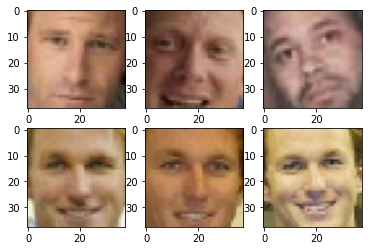

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.title('sample image')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i].transpose([1,2,0]))

print("X shape:",X.shape)
print("attr shape:",attr.shape)

### Autoencoder architecture

Let's design autoencoder as a single lasagne network, going from input image through bottleneck into the reconstructed image.

<img src="http://nghiaho.com/wp-content/uploads/2012/12/autoencoder_network1.png" width=640px>



## First step: PCA

Principial Component Analysis is a popular dimensionality reduction method. 

Under the hood, PCA attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;

In geometric terms, we want to find d axes along which most of variance occurs. The "natural" axes, if you wish.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/PCA_fish.png/256px-PCA_fish.png)


PCA can also be seen as a special case of an autoencoder.

* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X

Where Dense is a fully-connected layer with linear activaton:   $f(X) = W \cdot X + \vec b $


Note: the bias term in those layers is responsible for "centering" the matrix i.e. substracting mean.

In [8]:
class Reshape(nn.Module):
    """ this class corresponds to torch.reshape function and may be used as a reshape layer """
    def __init__(self, *shape):
        super().__init__()
        self.shape = shape
    def forward(self, input):
        return input.reshape(*self.shape)

In [9]:
class PCAAutoencoder(nn.Module):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    def __init__(self, code_size=50):
        super(PCAAutoencoder, self).__init__()
        self.enc = nn.Sequential(Reshape(-1, np.prod(img_shape)), nn.Linear(np.prod(img_shape), code_size))
        self.dec = nn.Sequential(nn.Linear(code_size, np.prod(img_shape)), Reshape(-1, img_shape[0], img_shape[1], img_shape[2])) 
    
    def batch_loss(self, batch, reference):
        reconstruction = self.dec(self.enc(batch))
        return torch.mean((reference - reconstruction) ** 2)

### Train the model

As usual, iterate minibatches of data and call train_step, then evaluate loss on validation data.

__Note to py2 users:__ you can safely drop `flush=True` from any code below.

In [10]:
from tqdm import tqdm
def train(model, dataset, dataset_test, num_epoch=32, gd=None, noise_function=None, noise_function_params=None):
    model.double()
    model.to(device)
    if gd is None:
        gd = optim.Adamax(model.parameters(), lr=0.002)
    if noise_function_params is None:
        noise_function_params = {}
    
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    losses = []
    dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)
    scores = []

    for epoch in range(num_epoch):
        model.train(True)
        for i, (batch) in tqdm(enumerate(dataloader)):
            gd.zero_grad()
            if noise_function is not None:
                batch_noised = noise_function(batch, **noise_function_params).to(device=device)
                loss = model.batch_loss(batch_noised, batch.to(device=device))
            else:
                batch = batch.to(device=device)
                loss = model.batch_loss(batch, batch)
            (loss).backward()
            losses.append(loss.data.cpu().numpy())
            gd.step()
            gd.zero_grad()
        train_mse = np.mean(losses[-(i+1):])
        
        model.train(False)
        for i, (batch) in enumerate(dataloader_test):
            batch = batch.to(device=device)
            scores.append(model.batch_loss(batch, batch).data.cpu().numpy())
        test_mse  = np.mean(scores[-(i+1):])

        print(f"{epoch+1}, Train loss: {train_mse}, Test loss: {test_mse}")

In [11]:
def visualize(img, model):
    """Draws original, encoded and decoded images"""
    model.train(False)
    code = model.enc(img[None].cuda(device=device))

    reco = model.dec(code)

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img.cpu().numpy().transpose([1, 2, 0]).clip(0, 1))

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.cpu().detach().numpy().reshape([code.shape[-1] // 2, -1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco[0].cpu().detach().numpy().transpose([1, 2, 0]).clip(0, 1))
    plt.show()

In [12]:
aenc = PCAAutoencoder()
train(aenc, X_train_tensor, X_test_tensor, 40)

370it [00:03, 101.83it/s]


1, Train loss: 0.10708823661536271, Test loss: 0.023703418829438855


370it [00:00, 377.56it/s]


2, Train loss: 0.023229504211119818, Test loss: 0.023118236504147006


370it [00:00, 380.93it/s]


3, Train loss: 0.022912617019210522, Test loss: 0.023006518157591173


370it [00:00, 386.26it/s]


4, Train loss: 0.022626348758615505, Test loss: 0.022659420782681062


370it [00:00, 387.08it/s]


5, Train loss: 0.02205209309487264, Test loss: 0.02175754803073155


370it [00:00, 383.74it/s]


6, Train loss: 0.020596524380715943, Test loss: 0.019909911294052257


370it [00:00, 384.86it/s]


7, Train loss: 0.01907057456289003, Test loss: 0.018665205962773396


370it [00:00, 383.67it/s]


8, Train loss: 0.018099686313745603, Test loss: 0.017791389082859238


370it [00:00, 382.97it/s]


9, Train loss: 0.01713680774317965, Test loss: 0.01683911025713845


370it [00:00, 377.06it/s]


10, Train loss: 0.016278218015495588, Test loss: 0.01571116226987913


370it [00:00, 373.47it/s]


11, Train loss: 0.015119278726515967, Test loss: 0.014420669496044118


370it [00:00, 381.61it/s]


12, Train loss: 0.013956657189405117, Test loss: 0.013111815334042815


370it [00:00, 381.71it/s]


13, Train loss: 0.012857056137951982, Test loss: 0.01301427706061097


370it [00:00, 381.60it/s]


14, Train loss: 0.011814886803777618, Test loss: 0.011334616811168163


370it [00:00, 384.16it/s]


15, Train loss: 0.010830474840189687, Test loss: 0.010300165288941968


370it [00:00, 384.66it/s]


16, Train loss: 0.010208748260381846, Test loss: 0.0101964803805286


370it [00:00, 384.59it/s]


17, Train loss: 0.009560920906632433, Test loss: 0.009182491077765514


370it [00:00, 380.45it/s]


18, Train loss: 0.008934013517072863, Test loss: 0.008607061285861447


370it [00:00, 383.27it/s]


19, Train loss: 0.008497814637856808, Test loss: 0.00840197057388343


370it [00:00, 378.87it/s]


20, Train loss: 0.008094252467590657, Test loss: 0.008385841909461138


370it [00:00, 380.10it/s]


21, Train loss: 0.007688426386790591, Test loss: 0.007402304842749111


370it [00:00, 373.59it/s]


22, Train loss: 0.007361264843510223, Test loss: 0.007142377027304005


370it [00:00, 375.73it/s]


23, Train loss: 0.007003885200050066, Test loss: 0.007153767479953947


370it [00:00, 379.69it/s]


24, Train loss: 0.006953616817720567, Test loss: 0.00688535018020345


370it [00:00, 378.09it/s]


25, Train loss: 0.006749236048120561, Test loss: 0.008123624985507621


370it [00:00, 376.70it/s]


26, Train loss: 0.006566048689524296, Test loss: 0.006616390887634423


370it [00:00, 374.07it/s]


27, Train loss: 0.006551881913113091, Test loss: 0.006464099409118375


370it [00:00, 377.35it/s]


28, Train loss: 0.0063653612292379, Test loss: 0.0063884503368059325


370it [00:00, 383.02it/s]


29, Train loss: 0.0063245526292226885, Test loss: 0.006326896009087893


370it [00:00, 376.71it/s]


30, Train loss: 0.006216520575630865, Test loss: 0.0063785772213439855


370it [00:00, 376.77it/s]


31, Train loss: 0.006192791702974587, Test loss: 0.006302900893543007


370it [00:00, 377.66it/s]


32, Train loss: 0.006091543684799126, Test loss: 0.006062891124504434


370it [00:00, 377.40it/s]


33, Train loss: 0.0060224928767982884, Test loss: 0.0060198629664988046


370it [00:00, 383.15it/s]


34, Train loss: 0.005993591973673519, Test loss: 0.005969503488355913


370it [00:00, 372.25it/s]


35, Train loss: 0.005920897887902949, Test loss: 0.006171296823968689


370it [00:00, 376.13it/s]


36, Train loss: 0.005936525592219331, Test loss: 0.006022540314482196


370it [00:00, 379.62it/s]


37, Train loss: 0.005893252058939162, Test loss: 0.005866271600743286


370it [00:00, 387.64it/s]


38, Train loss: 0.0058515487672481815, Test loss: 0.0058754673430133145


370it [00:00, 385.36it/s]


39, Train loss: 0.005798299202164683, Test loss: 0.005829548555293404


370it [00:00, 379.47it/s]


40, Train loss: 0.005773730509483997, Test loss: 0.005819310078659554


In [13]:
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch = batch.to(device=device)
    scores.append(aenc.batch_loss(batch, batch).data.cpu().numpy())
print (np.mean(scores))

0.0058261294676754515


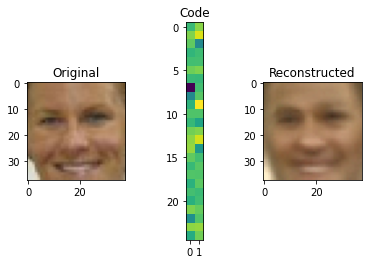

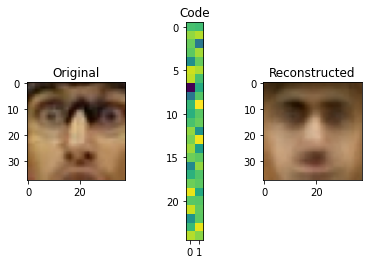

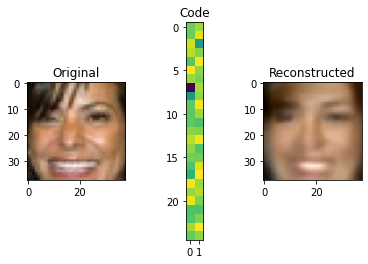

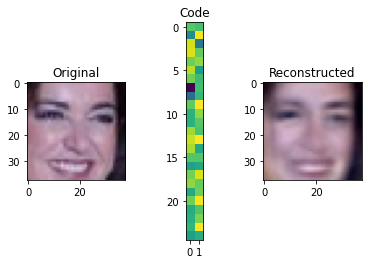

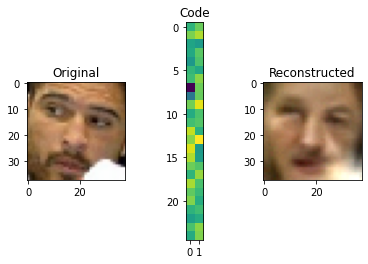

In [14]:
for i in range(5):
    img = X_test_tensor[i]
    visualize(img, aenc)


### Going deeper

PCA is neat but surely we can do better. This time we want you to build a deep autoencoder by... stacking more layers.

In particular, your encoder and decoder should be at least 3 layers deep each. You can use any nonlinearity you want and any number of hidden units in non-bottleneck layers provided you can actually afford training it.

![layers](https://pbs.twimg.com/media/CYggEo-VAAACg_n.png:small)

A few sanity checks:
* There shouldn't be any hidden layer smaller than bottleneck (encoder output).
* Don't forget to insert nonlinearities between intermediate dense layers.
* Convolutional layers are allowed but not required. To undo convolution use L.Deconv2D, pooling - L.UpSampling2D.
* Adding activation after bottleneck is allowed, but not strictly necessary.

In [15]:
class DeepAutoencoder(nn.Module):
    
    def __init__(self, code_size=32):
        super(DeepAutoencoder, self).__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(2, 2),
            Reshape((-1, 256 * 4 * 4)),
            nn.Linear(4096, 512),
            nn.ELU(),
            nn.Linear(512,code_size)
            )
        
        self.dec = nn.Sequential(
            nn.Linear(code_size, 512),
            nn.ELU(),
            nn.Linear(512, 4096),
            nn.ELU(),
            Reshape((-1, 256, 4, 4)),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2),
            nn.ELU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2),
            nn.ELU(),
            nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2),
            nn.Sigmoid(),
            Reshape((-1,3,38,38))
            )
    
    def batch_loss(self, batch, reference):
        a = self.enc(batch)
        reconstruction = self.dec(a)
        return torch.mean((reference - reconstruction)**2)

In [16]:
#Check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512,1024]:
    help_tensor = next(iter(DataLoader(X_train_tensor, batch_size=BATCH_SIZE)))
    model = DeepAutoencoder(code_size).float().to(device)
    encoder_out = model.enc(help_tensor.type('torch.FloatTensor').cuda(device))
    decoder_out = model.dec(encoder_out)
    print("Testing code size %i" % code_size)

    assert encoder_out.shape[1:] == torch.Size([code_size]),"encoder must output a code of required size"
    assert decoder_out.shape[1:] == img_shape,   "decoder must output an image of valid shape"

    assert (sum([1 + len(list(c1level.children())) for c1level in model.dec.children()]) >= 6),  "decoder must contain at least 3 dense layers"

    del encoder_out
    del decoder_out
    torch.cuda.empty_cache()
print("All tests passed!")

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
Testing code size 1024
All tests passed!


__Hint:__ if you're getting "Encoder layer is smaller than bottleneck" error, use code_size when defining intermediate layers. 

For example, such layer may have code_size*2 units.

In [42]:
aenc_deep = DeepAutoencoder()
train(aenc_deep, X_train_tensor, X_test_tensor, num_epoch=300)

370it [00:35, 10.32it/s]


1, Train loss: 0.014660262462716817, Test loss: 0.009588687971494389


370it [00:36, 10.14it/s]


2, Train loss: 0.00836280011408104, Test loss: 0.007808320720228543


370it [00:36, 10.21it/s]


3, Train loss: 0.00730094901740882, Test loss: 0.007209103051695649


370it [00:36, 10.20it/s]


4, Train loss: 0.00693105193651909, Test loss: 0.00716691609019755


370it [00:36, 10.21it/s]


5, Train loss: 0.006658246958663906, Test loss: 0.006698997911612155


370it [00:36, 10.19it/s]


6, Train loss: 0.006372847042932666, Test loss: 0.006603772980107175


370it [00:36, 10.20it/s]


7, Train loss: 0.00618225858995512, Test loss: 0.006444714815776485


370it [00:36, 10.19it/s]


8, Train loss: 0.0060071073427631376, Test loss: 0.006299801317418576


370it [00:36, 10.20it/s]


9, Train loss: 0.005834758805109071, Test loss: 0.0060941667851735345


370it [00:36, 10.18it/s]


10, Train loss: 0.005696921216899969, Test loss: 0.006066161667131718


370it [00:36, 10.19it/s]


11, Train loss: 0.005541139957948252, Test loss: 0.006089785185876569


370it [00:36, 10.20it/s]


12, Train loss: 0.0054235142547706195, Test loss: 0.0061877583762643155


370it [00:36, 10.19it/s]


13, Train loss: 0.005286231217559037, Test loss: 0.006036711095620249


370it [00:36, 10.19it/s]


14, Train loss: 0.005179123927333784, Test loss: 0.005963350712443939


370it [00:36, 10.20it/s]


15, Train loss: 0.0050685872991093955, Test loss: 0.005988945843804


370it [00:36, 10.20it/s]


16, Train loss: 0.004964835307128579, Test loss: 0.005967711580608941


370it [00:36, 10.21it/s]


17, Train loss: 0.004860935779719608, Test loss: 0.005886714942608551


370it [00:36, 10.20it/s]


18, Train loss: 0.004764406181577058, Test loss: 0.006010219995912094


370it [00:36, 10.20it/s]


19, Train loss: 0.004682393782497882, Test loss: 0.005929700947768039


370it [00:36, 10.18it/s]


20, Train loss: 0.004589511609749886, Test loss: 0.005966146716870763


370it [00:36, 10.16it/s]


21, Train loss: 0.004507870169346862, Test loss: 0.006073823036245161


370it [00:36, 10.15it/s]


22, Train loss: 0.004434292925067441, Test loss: 0.006071023940760918


370it [00:36, 10.15it/s]


23, Train loss: 0.004354380313020862, Test loss: 0.006066864485483356


370it [00:36, 10.14it/s]


24, Train loss: 0.004272066616457012, Test loss: 0.006003112723779409


370it [00:36, 10.14it/s]


25, Train loss: 0.004208400013716901, Test loss: 0.006042324707670864


370it [00:36, 10.14it/s]


26, Train loss: 0.00414367353873099, Test loss: 0.006149380995447072


370it [00:36, 10.14it/s]


27, Train loss: 0.0040738321033667955, Test loss: 0.006037095683892645


370it [00:36, 10.13it/s]


28, Train loss: 0.004013093136923365, Test loss: 0.006262317856620146


370it [00:36, 10.14it/s]


29, Train loss: 0.003952846460246376, Test loss: 0.006247847962849192


370it [00:36, 10.15it/s]


30, Train loss: 0.003902702330682935, Test loss: 0.006209758562967217


370it [00:36, 10.13it/s]


31, Train loss: 0.0038452796191382568, Test loss: 0.006405109449381027


370it [00:36, 10.13it/s]


32, Train loss: 0.0037917037822285554, Test loss: 0.006304855086082932


370it [00:36, 10.12it/s]


33, Train loss: 0.003740411959400391, Test loss: 0.006320084651085866


370it [00:36, 10.15it/s]


34, Train loss: 0.003695352373144739, Test loss: 0.006271150220222023


370it [00:36, 10.14it/s]


35, Train loss: 0.003641303714771153, Test loss: 0.006354356661913733


370it [00:36, 10.13it/s]


36, Train loss: 0.0036063045338120205, Test loss: 0.006352651306305536


370it [00:36, 10.13it/s]


37, Train loss: 0.0035566378715742404, Test loss: 0.006398318829598532


370it [00:36, 10.16it/s]


38, Train loss: 0.0035182287729232336, Test loss: 0.006342602371874842


370it [00:36, 10.13it/s]


39, Train loss: 0.003480813826189359, Test loss: 0.006456404247782896


370it [00:36, 10.13it/s]


40, Train loss: 0.003441514264973761, Test loss: 0.006481505742675629


370it [00:36, 10.19it/s]


41, Train loss: 0.003410411270439855, Test loss: 0.006475653227177333


370it [00:36, 10.14it/s]


42, Train loss: 0.0033666924945667575, Test loss: 0.006582318902572841


370it [00:36, 10.14it/s]


43, Train loss: 0.003338559209977025, Test loss: 0.006477767878570961


370it [00:36, 10.13it/s]


44, Train loss: 0.0033049869630826256, Test loss: 0.006504875092365416


370it [00:36, 10.13it/s]


45, Train loss: 0.003278461264201187, Test loss: 0.0066109279905636935


370it [00:36, 10.16it/s]


46, Train loss: 0.0032425086626666527, Test loss: 0.006591566423972254


370it [00:36, 10.14it/s]


47, Train loss: 0.0032135888730916913, Test loss: 0.006645542779432499


370it [00:36, 10.14it/s]


48, Train loss: 0.003190823849247535, Test loss: 0.006627283669783942


370it [00:36, 10.15it/s]


49, Train loss: 0.003153187430442343, Test loss: 0.006622439591858012


370it [00:36, 10.15it/s]


50, Train loss: 0.003138312534318224, Test loss: 0.006722456492389499


370it [00:36, 10.15it/s]


51, Train loss: 0.0031055269951788065, Test loss: 0.006693734007274998


370it [00:36, 10.15it/s]


52, Train loss: 0.0030825262424545026, Test loss: 0.006732277249594861


370it [00:36, 10.18it/s]


53, Train loss: 0.0030623150428467174, Test loss: 0.006760735791011956


370it [00:36, 10.15it/s]


54, Train loss: 0.0030306757712786404, Test loss: 0.006761358983328061


370it [00:36, 10.16it/s]


55, Train loss: 0.0030170561339715168, Test loss: 0.006754652527264227


370it [00:36, 10.16it/s]


56, Train loss: 0.0029944760676451757, Test loss: 0.006814013363037865


370it [00:36, 10.16it/s]


57, Train loss: 0.0029689598983593324, Test loss: 0.006916327265784524


370it [00:36, 10.16it/s]


58, Train loss: 0.0029496690345666076, Test loss: 0.00680210660460671


370it [00:36, 10.16it/s]


59, Train loss: 0.0029250899359784823, Test loss: 0.006799835566512892


370it [00:36, 10.16it/s]


60, Train loss: 0.0029074755890622283, Test loss: 0.006929843825317696


370it [00:36, 10.15it/s]


61, Train loss: 0.002896684902900421, Test loss: 0.00694172809239244


370it [00:36, 10.14it/s]


62, Train loss: 0.002882736209659265, Test loss: 0.0068563069511988275


370it [00:36, 10.15it/s]


63, Train loss: 0.00285610381365863, Test loss: 0.006907817046074841


370it [00:36, 10.15it/s]


64, Train loss: 0.0028372690926349304, Test loss: 0.006890706678693174


370it [00:36, 10.13it/s]


65, Train loss: 0.002818188273100399, Test loss: 0.006932885716216871


370it [00:36, 10.15it/s]


66, Train loss: 0.0028098208082193124, Test loss: 0.0069599171648695194


370it [00:36, 10.15it/s]


67, Train loss: 0.002791205690235042, Test loss: 0.006941348974334574


370it [00:36, 10.16it/s]


68, Train loss: 0.0027758842228749305, Test loss: 0.006924139209873407


370it [00:36, 10.17it/s]


69, Train loss: 0.0027677526586990762, Test loss: 0.006992335078716527


370it [00:36, 10.16it/s]


70, Train loss: 0.0027457409085625386, Test loss: 0.00703658038924135


370it [00:36, 10.16it/s]


71, Train loss: 0.0027283122227749297, Test loss: 0.007077910531468213


370it [00:36, 10.16it/s]


72, Train loss: 0.002721799575931975, Test loss: 0.007022498597176147


370it [00:36, 10.15it/s]


73, Train loss: 0.002698615501614734, Test loss: 0.0070644308281917045


370it [00:36, 10.12it/s]


74, Train loss: 0.0026874893143412587, Test loss: 0.00710084860306751


370it [00:36, 10.14it/s]


75, Train loss: 0.002677397867684771, Test loss: 0.007097119120038089


370it [00:36, 10.14it/s]


76, Train loss: 0.0026627397012046984, Test loss: 0.007075036595452054


370it [00:36, 10.15it/s]


77, Train loss: 0.002650298397387605, Test loss: 0.00714011146140968


370it [00:36, 10.14it/s]


78, Train loss: 0.002638597194581912, Test loss: 0.007094971848841329


370it [00:36, 10.14it/s]


79, Train loss: 0.002630536065477755, Test loss: 0.007162807668639314


370it [00:36, 10.15it/s]


80, Train loss: 0.0026189929911064453, Test loss: 0.007138395964435115


370it [00:36, 10.12it/s]


81, Train loss: 0.0026023629685236163, Test loss: 0.007112255276398091


370it [00:36, 10.14it/s]


82, Train loss: 0.0025942608697690334, Test loss: 0.007168614491579529


370it [00:36, 10.15it/s]


83, Train loss: 0.002585800184215417, Test loss: 0.007227571744864242


370it [00:36, 10.13it/s]


84, Train loss: 0.0025693284010298214, Test loss: 0.007170950532909508


370it [00:36, 10.14it/s]


85, Train loss: 0.0025625851989747096, Test loss: 0.007235004165389427


370it [00:36, 10.14it/s]


86, Train loss: 0.0025486857848592294, Test loss: 0.007347789866613623


370it [00:36, 10.13it/s]


87, Train loss: 0.002545173417083565, Test loss: 0.007202148720886879


370it [00:36, 10.12it/s]


88, Train loss: 0.0025328601128152034, Test loss: 0.007310474450210246


370it [00:36, 10.12it/s]


89, Train loss: 0.0025191047908341107, Test loss: 0.007221658732243723


370it [00:36, 10.13it/s]


90, Train loss: 0.0025147610764425896, Test loss: 0.00727020326631931


370it [00:36, 10.12it/s]


91, Train loss: 0.0025083950074562687, Test loss: 0.007336365779278463


370it [00:36, 10.12it/s]


92, Train loss: 0.0025017875661005515, Test loss: 0.007332114814300054


370it [00:36, 10.12it/s]


93, Train loss: 0.0024863182129450548, Test loss: 0.007309763432101264


370it [00:36, 10.13it/s]


94, Train loss: 0.002481094109674254, Test loss: 0.007192270070708028


370it [00:36, 10.15it/s]


95, Train loss: 0.0024711758992584554, Test loss: 0.007331877243722503


370it [00:36, 10.15it/s]


96, Train loss: 0.0024597455206194336, Test loss: 0.00740226133614756


370it [00:36, 10.14it/s]


97, Train loss: 0.0024544541044485544, Test loss: 0.007378486546441382


370it [00:36, 10.13it/s]


98, Train loss: 0.0024425959255773245, Test loss: 0.00735069662044184


370it [00:36, 10.13it/s]


99, Train loss: 0.002436617230999057, Test loss: 0.00741517318054795


370it [00:36, 10.13it/s]


100, Train loss: 0.002427332183946952, Test loss: 0.007509318993943145


370it [00:36, 10.19it/s]


101, Train loss: 0.002419769145698096, Test loss: 0.007358434178730649


370it [00:36, 10.15it/s]


102, Train loss: 0.00241258655595481, Test loss: 0.007400997595293534


370it [00:36, 10.13it/s]


103, Train loss: 0.002405260591988097, Test loss: 0.007449955438879198


370it [00:36, 10.14it/s]


104, Train loss: 0.002405937642126, Test loss: 0.007376580205530849


370it [00:36, 10.14it/s]


105, Train loss: 0.002388514485807416, Test loss: 0.0074782728431187296


370it [00:36, 10.14it/s]


106, Train loss: 0.002377607928499694, Test loss: 0.00741519719149616


370it [00:36, 10.14it/s]


107, Train loss: 0.0023785297542128652, Test loss: 0.007430708017044341


370it [00:36, 10.11it/s]


108, Train loss: 0.0023763207108585685, Test loss: 0.007416244017410358


370it [00:36, 10.13it/s]


109, Train loss: 0.0023592347347733233, Test loss: 0.0073844853609940165


370it [00:36, 10.15it/s]


110, Train loss: 0.0023543633513413314, Test loss: 0.007475592725549101


370it [00:36, 10.15it/s]


111, Train loss: 0.002350458141049012, Test loss: 0.007510022181054573


370it [00:36, 10.16it/s]


112, Train loss: 0.002344787510622032, Test loss: 0.007469560870790467


370it [00:36, 10.16it/s]


113, Train loss: 0.002334714734793769, Test loss: 0.007447895374481314


370it [00:36, 10.15it/s]


114, Train loss: 0.0023336682179221704, Test loss: 0.007419818095052576


370it [00:36, 10.14it/s]


115, Train loss: 0.0023266503185858612, Test loss: 0.0074260571876937605


370it [00:36, 10.16it/s]


116, Train loss: 0.002313558983235883, Test loss: 0.00753810829377758


370it [00:36, 10.16it/s]


117, Train loss: 0.002312637072099344, Test loss: 0.007475714937475899


370it [00:36, 10.16it/s]


118, Train loss: 0.0023097865266277088, Test loss: 0.007507707747214325


370it [00:36, 10.20it/s]


119, Train loss: 0.002303691247308698, Test loss: 0.007438392521501423


370it [00:36, 10.16it/s]


120, Train loss: 0.0022909100724561766, Test loss: 0.007580850071651067


370it [00:36, 10.16it/s]


121, Train loss: 0.0022955341453590387, Test loss: 0.007574099911353862


370it [00:36, 10.19it/s]


122, Train loss: 0.002279087441493257, Test loss: 0.007548550408067181


370it [00:36, 10.15it/s]


123, Train loss: 0.0022785367411239247, Test loss: 0.007519534086745141


370it [00:36, 10.16it/s]


124, Train loss: 0.002276196771253346, Test loss: 0.007580188768024261


370it [00:36, 10.15it/s]


125, Train loss: 0.0022682387481568474, Test loss: 0.007529134542142187


370it [00:36, 10.16it/s]


126, Train loss: 0.0022678667973517704, Test loss: 0.007606619588039408


370it [00:36, 10.17it/s]


127, Train loss: 0.0022567495121312963, Test loss: 0.007572925609421181


370it [00:36, 10.15it/s]


128, Train loss: 0.002249162185151593, Test loss: 0.007600173965282627


370it [00:36, 10.15it/s]


129, Train loss: 0.002244524090592543, Test loss: 0.007612644721406259


370it [00:36, 10.16it/s]


130, Train loss: 0.002244671093284287, Test loss: 0.007593184904061922


370it [00:36, 10.16it/s]


131, Train loss: 0.0022343712232007176, Test loss: 0.007550835418876319


370it [00:36, 10.21it/s]


132, Train loss: 0.0022298800388936327, Test loss: 0.007601056801498492


370it [00:36, 10.16it/s]


133, Train loss: 0.0022230992193047064, Test loss: 0.007508055414512062


370it [00:36, 10.16it/s]


134, Train loss: 0.002221162605791324, Test loss: 0.0076932405898813986


370it [00:36, 10.20it/s]


135, Train loss: 0.0022198419847578406, Test loss: 0.0076082637236861385


370it [00:36, 10.15it/s]


136, Train loss: 0.0022128185710200256, Test loss: 0.007648927992296188


370it [00:36, 10.15it/s]


137, Train loss: 0.0022076421194197754, Test loss: 0.007653618199307965


370it [00:36, 10.17it/s]


138, Train loss: 0.002205542985002773, Test loss: 0.007700995994252855


370it [00:36, 10.20it/s]


139, Train loss: 0.0022071263607977487, Test loss: 0.007664836800331774


370it [00:36, 10.21it/s]


140, Train loss: 0.0021996731471598937, Test loss: 0.007677513796860372


370it [00:36, 10.19it/s]


141, Train loss: 0.002192984631787603, Test loss: 0.007594129534458273


370it [00:36, 10.18it/s]


142, Train loss: 0.0021824885312738368, Test loss: 0.007679769652099831


370it [00:36, 10.20it/s]


143, Train loss: 0.002185483017703775, Test loss: 0.007731197704296165


370it [00:36, 10.19it/s]


144, Train loss: 0.002176422776126955, Test loss: 0.007653959717399537


370it [00:36, 10.19it/s]


145, Train loss: 0.002177519630849459, Test loss: 0.007688052761952313


370it [00:36, 10.19it/s]


146, Train loss: 0.002171857220276398, Test loss: 0.007690979629213686


370it [00:36, 10.19it/s]


147, Train loss: 0.002165510357878224, Test loss: 0.007650100360436616


370it [00:36, 10.19it/s]


148, Train loss: 0.0021620425434691185, Test loss: 0.007696818288248956


370it [00:36, 10.23it/s]


149, Train loss: 0.002157355967260504, Test loss: 0.0077812075556590735


370it [00:36, 10.20it/s]


150, Train loss: 0.0021564336196682873, Test loss: 0.007691729869499476


370it [00:36, 10.25it/s]


151, Train loss: 0.0021465575673756923, Test loss: 0.007808144736534302


370it [00:36, 10.21it/s]


152, Train loss: 0.0021493135400793193, Test loss: 0.007684225496955434


370it [00:36, 10.21it/s]


153, Train loss: 0.0021453127251531965, Test loss: 0.007770207069163114


370it [00:36, 10.21it/s]


154, Train loss: 0.0021356374562217953, Test loss: 0.007716911763531325


370it [00:36, 10.23it/s]


155, Train loss: 0.0021348050469122775, Test loss: 0.00774043213655839


370it [00:36, 10.20it/s]


156, Train loss: 0.0021361296933094143, Test loss: 0.007766610407228004


370it [00:36, 10.23it/s]


157, Train loss: 0.0021259865677837313, Test loss: 0.007871379654860382


370it [00:36, 10.21it/s]


158, Train loss: 0.002124019219023694, Test loss: 0.007701757918510714


370it [00:36, 10.20it/s]


159, Train loss: 0.0021183281416196137, Test loss: 0.007761145669865885


370it [00:36, 10.20it/s]


160, Train loss: 0.0021169331347572883, Test loss: 0.0077225394946658825


370it [00:36, 10.16it/s]


161, Train loss: 0.0021161432608624736, Test loss: 0.007799396767026863


370it [00:36, 10.19it/s]


162, Train loss: 0.0021124574486337403, Test loss: 0.0077814296412282635


370it [00:36, 10.20it/s]


163, Train loss: 0.0021070629518067365, Test loss: 0.0078022684215227804


370it [00:36, 10.19it/s]


164, Train loss: 0.002102276719598842, Test loss: 0.0078519701739603


370it [00:36, 10.19it/s]


165, Train loss: 0.002100419170367528, Test loss: 0.0077643570292062255


370it [00:36, 10.19it/s]


166, Train loss: 0.0020978241457364224, Test loss: 0.007807007535514536


370it [00:36, 10.20it/s]


167, Train loss: 0.00209311803488573, Test loss: 0.007747612708374098


370it [00:36, 10.24it/s]


168, Train loss: 0.0020958678245188225, Test loss: 0.007772027940687485


370it [00:36, 10.19it/s]


169, Train loss: 0.0020854307417498873, Test loss: 0.0077691606644651285


370it [00:36, 10.20it/s]


170, Train loss: 0.0020836051417170583, Test loss: 0.007811822274194247


370it [00:36, 10.20it/s]


171, Train loss: 0.0020776672394831838, Test loss: 0.007821018026839297


370it [00:36, 10.20it/s]


172, Train loss: 0.002076782346526716, Test loss: 0.0077944006717754625


370it [00:36, 10.19it/s]


173, Train loss: 0.002075196281885574, Test loss: 0.007842999149121633


370it [00:36, 10.20it/s]


174, Train loss: 0.002070588444147744, Test loss: 0.007774275929644121


370it [00:36, 10.20it/s]


175, Train loss: 0.0020688197874245222, Test loss: 0.007825642195133877


370it [00:36, 10.23it/s]


176, Train loss: 0.002060815574294277, Test loss: 0.007833539561328437


370it [00:36, 10.20it/s]


177, Train loss: 0.0020631539053881727, Test loss: 0.00799531489106404


370it [00:36, 10.20it/s]


178, Train loss: 0.0020602517490665028, Test loss: 0.007899817538629037


370it [00:36, 10.20it/s]


179, Train loss: 0.0020531750786672077, Test loss: 0.007888369355326975


370it [00:36, 10.19it/s]


180, Train loss: 0.0020544484342410146, Test loss: 0.007900092375997163


370it [00:36, 10.21it/s]


181, Train loss: 0.0020523715213335526, Test loss: 0.007838217023899429


370it [00:36, 10.23it/s]


182, Train loss: 0.0020496190904292673, Test loss: 0.007867094974991903


370it [00:36, 10.21it/s]


183, Train loss: 0.0020484043312995405, Test loss: 0.007872666119087716


370it [00:36, 10.21it/s]


184, Train loss: 0.002043428130619813, Test loss: 0.007861245025369803


370it [00:36, 10.19it/s]


185, Train loss: 0.00204255948436731, Test loss: 0.007866968088969275


370it [00:36, 10.18it/s]


186, Train loss: 0.0020382880061298415, Test loss: 0.007938692881593174


370it [00:36, 10.18it/s]


187, Train loss: 0.002029408308865403, Test loss: 0.007919633902041862


370it [00:36, 10.19it/s]


188, Train loss: 0.0020308304026269916, Test loss: 0.007924644839397116


370it [00:36, 10.17it/s]


189, Train loss: 0.0020257629958222393, Test loss: 0.007964894321142293


370it [00:36, 10.18it/s]


190, Train loss: 0.002025639848221469, Test loss: 0.007870153871822822


370it [00:36, 10.18it/s]


191, Train loss: 0.0020256173188245422, Test loss: 0.007968055682380468


370it [00:36, 10.19it/s]


192, Train loss: 0.0020175594524412042, Test loss: 0.007948751165363869


370it [00:36, 10.22it/s]


193, Train loss: 0.0020191813824861995, Test loss: 0.007893222265093813


370it [00:36, 10.18it/s]


194, Train loss: 0.002020951206108042, Test loss: 0.007873142124237956


370it [00:36, 10.20it/s]


195, Train loss: 0.0020073117895843006, Test loss: 0.008131439230112072


370it [00:36, 10.17it/s]


196, Train loss: 0.0020106400921195127, Test loss: 0.007894275763213596


370it [00:36, 10.18it/s]


197, Train loss: 0.002010453670874471, Test loss: 0.007936641965846767


370it [00:36, 10.17it/s]


198, Train loss: 0.002003761037037758, Test loss: 0.008029111443378653


370it [00:36, 10.19it/s]


199, Train loss: 0.001998931991979435, Test loss: 0.007940064024781817


370it [00:36, 10.15it/s]


200, Train loss: 0.0020029342846579114, Test loss: 0.008024491518935504


370it [00:36, 10.18it/s]


201, Train loss: 0.0019980921281817425, Test loss: 0.0080230147538477


370it [00:36, 10.17it/s]


202, Train loss: 0.0020006913270498292, Test loss: 0.007959447584452993


370it [00:36, 10.18it/s]


203, Train loss: 0.0019935921030962687, Test loss: 0.008032830403276982


370it [00:36, 10.18it/s]


204, Train loss: 0.001993223301853225, Test loss: 0.008018184204010115


370it [00:36, 10.18it/s]


205, Train loss: 0.001989099773558239, Test loss: 0.008033708242426232


370it [00:36, 10.19it/s]


206, Train loss: 0.0019897508740729635, Test loss: 0.007988653073125953


370it [00:36, 10.18it/s]


207, Train loss: 0.0019794686425820287, Test loss: 0.00796864000792731


370it [00:36, 10.17it/s]


208, Train loss: 0.00197917280829165, Test loss: 0.008027374774591681


370it [00:36, 10.19it/s]


209, Train loss: 0.001981253645666395, Test loss: 0.008091812429207635


370it [00:36, 10.18it/s]


210, Train loss: 0.001978059416998649, Test loss: 0.008074245715708002


370it [00:36, 10.18it/s]


211, Train loss: 0.0019739894786265314, Test loss: 0.007906718338596883


370it [00:36, 10.19it/s]


212, Train loss: 0.001971422632848733, Test loss: 0.007993308584202625


370it [00:36, 10.23it/s]


213, Train loss: 0.0019706834209547467, Test loss: 0.008094744724373316


370it [00:36, 10.18it/s]


214, Train loss: 0.001967331735000149, Test loss: 0.008123664322105232


370it [00:36, 10.18it/s]


215, Train loss: 0.001967235130878711, Test loss: 0.00796912119675349


370it [00:36, 10.18it/s]


216, Train loss: 0.001961998470212239, Test loss: 0.008043518772782827


370it [00:36, 10.17it/s]


217, Train loss: 0.001962057219855381, Test loss: 0.007963228685427834


370it [00:36, 10.18it/s]


218, Train loss: 0.0019581633152842438, Test loss: 0.008062525285715941


370it [00:36, 10.22it/s]


219, Train loss: 0.0019566801841953106, Test loss: 0.007992159442871441


370it [00:36, 10.27it/s]


220, Train loss: 0.0019548490828617086, Test loss: 0.007996068376008159


370it [00:36, 10.21it/s]


221, Train loss: 0.0019559743683286905, Test loss: 0.008016440122451502


370it [00:36, 10.21it/s]


222, Train loss: 0.0019495711019550171, Test loss: 0.008105095080252159


370it [00:36, 10.21it/s]


223, Train loss: 0.0019472933219229713, Test loss: 0.008070406212529385


370it [00:36, 10.19it/s]


224, Train loss: 0.001946097407744875, Test loss: 0.00798832913333052


370it [00:36, 10.24it/s]


225, Train loss: 0.0019432747815196435, Test loss: 0.008114919192251194


370it [00:36, 10.21it/s]


226, Train loss: 0.001943025218548675, Test loss: 0.008031993065973495


370it [00:36, 10.21it/s]


227, Train loss: 0.0019411239121451512, Test loss: 0.00808366900711097


370it [00:36, 10.22it/s]


228, Train loss: 0.0019399065622120193, Test loss: 0.008149365509635196


370it [00:36, 10.22it/s]


229, Train loss: 0.0019379817142270845, Test loss: 0.00806645175302038


370it [00:36, 10.18it/s]


230, Train loss: 0.0019386483511258108, Test loss: 0.008094283111741134


370it [00:36, 10.21it/s]


231, Train loss: 0.0019297150663903438, Test loss: 0.008084647217659295


370it [00:36, 10.22it/s]


232, Train loss: 0.0019304675142771965, Test loss: 0.00804996064223269


370it [00:36, 10.22it/s]


233, Train loss: 0.001929287799697626, Test loss: 0.008069066723490175


370it [00:36, 10.22it/s]


234, Train loss: 0.0019305055684561007, Test loss: 0.008082230149625304


370it [00:36, 10.22it/s]


235, Train loss: 0.0019253158571355742, Test loss: 0.008137094012694215


370it [00:36, 10.23it/s]


236, Train loss: 0.0019222018096463859, Test loss: 0.008103024243991319


370it [00:36, 10.19it/s]


237, Train loss: 0.0019217485890530733, Test loss: 0.008164690765457552


370it [00:36, 10.22it/s]


238, Train loss: 0.001923136526005285, Test loss: 0.008030309181367476


370it [00:36, 10.21it/s]


239, Train loss: 0.001924434261277221, Test loss: 0.008115236427027613


370it [00:36, 10.22it/s]


240, Train loss: 0.001914717920131207, Test loss: 0.008141846752345396


370it [00:36, 10.22it/s]


241, Train loss: 0.0019145397710174244, Test loss: 0.008141684033564734


370it [00:36, 10.23it/s]


242, Train loss: 0.0019189285382400195, Test loss: 0.008380742893207947


370it [00:36, 10.22it/s]


243, Train loss: 0.001910523188920537, Test loss: 0.008243818936801813


370it [00:36, 10.20it/s]


244, Train loss: 0.0019087323273538662, Test loss: 0.008102703351610525


370it [00:36, 10.20it/s]


245, Train loss: 0.0019062067975091552, Test loss: 0.008116727463974516


370it [00:36, 10.20it/s]


246, Train loss: 0.0019057980905630727, Test loss: 0.00814401244625221


370it [00:36, 10.21it/s]


247, Train loss: 0.001905153160040014, Test loss: 0.008105935321135311


370it [00:36, 10.22it/s]


248, Train loss: 0.0018991581649940906, Test loss: 0.008244702019068077


370it [00:36, 10.24it/s]


249, Train loss: 0.0019045625246567088, Test loss: 0.008176016828961801


370it [00:36, 10.22it/s]


250, Train loss: 0.0018965515257221629, Test loss: 0.008224314694887295


370it [00:36, 10.23it/s]


251, Train loss: 0.001902150812362205, Test loss: 0.008311859927369413


370it [00:36, 10.22it/s]


252, Train loss: 0.0018912091580034881, Test loss: 0.00814429004457656


370it [00:36, 10.21it/s]


253, Train loss: 0.0018932571107321168, Test loss: 0.008139934309965837


370it [00:36, 10.22it/s]


254, Train loss: 0.0018926895305230954, Test loss: 0.008226913832659274


370it [00:36, 10.23it/s]


255, Train loss: 0.001891732403276418, Test loss: 0.008110022413367609


370it [00:36, 10.20it/s]


256, Train loss: 0.0018891366497934858, Test loss: 0.008177428469939924


370it [00:36, 10.21it/s]


257, Train loss: 0.0018889436174640728, Test loss: 0.008191606863637653


370it [00:36, 10.21it/s]


258, Train loss: 0.0018880617904088928, Test loss: 0.008212359357432829


370it [00:36, 10.21it/s]


259, Train loss: 0.001884752263591897, Test loss: 0.008123750231881761


370it [00:36, 10.20it/s]


260, Train loss: 0.0018849381584241077, Test loss: 0.008196270386679801


370it [00:36, 10.24it/s]


261, Train loss: 0.0018826555938652057, Test loss: 0.008233339836007766


370it [00:36, 10.22it/s]


262, Train loss: 0.0018793137284666673, Test loss: 0.00818279221132374


370it [00:36, 10.21it/s]


263, Train loss: 0.0018749620128855138, Test loss: 0.008267206333099339


370it [00:36, 10.21it/s]


264, Train loss: 0.0018776646917008431, Test loss: 0.008286516823137876


370it [00:36, 10.22it/s]


265, Train loss: 0.0018753802818015034, Test loss: 0.008190015146902355


370it [00:36, 10.23it/s]


266, Train loss: 0.001873310002865146, Test loss: 0.008183668211410297


370it [00:36, 10.26it/s]


267, Train loss: 0.0018718492232375863, Test loss: 0.008287809547788896


370it [00:36, 10.22it/s]


268, Train loss: 0.0018701697414181715, Test loss: 0.008295339913635052


370it [00:36, 10.21it/s]


269, Train loss: 0.0018678746523088604, Test loss: 0.00831162980580155


370it [00:36, 10.21it/s]


270, Train loss: 0.0018695179636138936, Test loss: 0.008225376015094042


370it [00:36, 10.21it/s]


271, Train loss: 0.0018688061034082355, Test loss: 0.00836639630348766


370it [00:36, 10.22it/s]


272, Train loss: 0.0018650014382375752, Test loss: 0.008163297122060124


370it [00:36, 10.19it/s]


273, Train loss: 0.001864867320255981, Test loss: 0.008170451688911961


370it [00:36, 10.19it/s]


274, Train loss: 0.001864419042557208, Test loss: 0.008232558631004513


370it [00:36, 10.21it/s]


275, Train loss: 0.0018640562139021898, Test loss: 0.00828629732323751


370it [00:36, 10.20it/s]


276, Train loss: 0.0018582789448061514, Test loss: 0.008265778568002636


370it [00:36, 10.19it/s]


277, Train loss: 0.00186000717977289, Test loss: 0.008168523122523521


370it [00:36, 10.20it/s]


278, Train loss: 0.001856910623742157, Test loss: 0.008226815589307537


370it [00:36, 10.22it/s]


279, Train loss: 0.0018533781959416966, Test loss: 0.00825031717196035


370it [00:36, 10.21it/s]


280, Train loss: 0.0018539351162712755, Test loss: 0.00823614722694219


370it [00:36, 10.19it/s]


281, Train loss: 0.001852498401917366, Test loss: 0.008312189922497413


370it [00:36, 10.20it/s]


282, Train loss: 0.0018533585206811155, Test loss: 0.008230207249129755


370it [00:36, 10.21it/s]


283, Train loss: 0.0018481703653651482, Test loss: 0.008244595384397032


370it [00:36, 10.19it/s]


284, Train loss: 0.0018461714529785548, Test loss: 0.008290975533303088


370it [00:36, 10.23it/s]


285, Train loss: 0.0018504103767341955, Test loss: 0.008269703287837575


370it [00:36, 10.22it/s]


286, Train loss: 0.0018450689418608964, Test loss: 0.00830398104578504


370it [00:36, 10.22it/s]


287, Train loss: 0.001844122461115962, Test loss: 0.00819312896220086


370it [00:36, 10.20it/s]


288, Train loss: 0.0018428985062511674, Test loss: 0.00830475034676333


370it [00:36, 10.20it/s]


289, Train loss: 0.0018406848598009323, Test loss: 0.008322127710332788


370it [00:36, 10.18it/s]


290, Train loss: 0.001836514443983998, Test loss: 0.008303028006731713


370it [00:36, 10.22it/s]


291, Train loss: 0.001840541096090661, Test loss: 0.00828008161136419


370it [00:36, 10.19it/s]


292, Train loss: 0.0018390765177951033, Test loss: 0.008287160803764496


370it [00:36, 10.21it/s]


293, Train loss: 0.0018356250912705955, Test loss: 0.008305499436125923


370it [00:36, 10.20it/s]


294, Train loss: 0.0018320961599210448, Test loss: 0.00825806205174971


370it [00:36, 10.20it/s]


295, Train loss: 0.0018313136228854164, Test loss: 0.008284302125005033


370it [00:36, 10.19it/s]


296, Train loss: 0.001832691748949239, Test loss: 0.008282502412226117


370it [00:36, 10.26it/s]


297, Train loss: 0.0018331712824965428, Test loss: 0.00835209351415408


370it [00:36, 10.21it/s]


298, Train loss: 0.0018315594348800239, Test loss: 0.008283374069630653


370it [00:36, 10.21it/s]


299, Train loss: 0.0018284179076790072, Test loss: 0.008270892236736913


370it [00:36, 10.20it/s]


300, Train loss: 0.0018242017362019769, Test loss: 0.008275586653964436


Training may take long, it's okay.

In [43]:
aenc_deep.train(False)
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch = batch.to(device=device)
    scores.append(aenc_deep.batch_loss(batch, batch).data.cpu().numpy())
    encoder_out = aenc_deep.enc(batch)
reconstruction_mse  = np.mean(scores)
print("MSE:", reconstruction_mse)

assert reconstruction_mse <= 0.0055, "Compression is too lossy. See tips below."
assert len(encoder_out.shape) == 2 and encoder_out.shape[1] == 32, "Make sure encoder has code_size units"
print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = X_test_tensor[i]
    visualize(img,aenc_deep)

MSE: 0.008338110490150364


AssertionError: ignored

**Couldn't overcome this assert. I guess due to architecture of the nn or poor convergence (though the number of epochs = 300). Everything else below seens to work fine.**

## Denoising AutoEncoder

Let's now make our model into a denoising autoencoder.

We'll keep your model architecture, but change the way it trains. In particular, we'll corrupt it's input data randomly before each epoch.

There are many strategies to apply noise. We'll implement two popular one: adding gaussian noise and using dropout.

In [21]:
def apply_gaussian_noise(X, sigma=0.1):
    """
    adds noise from normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    """
    noise = np.random.normal(scale=sigma, size=X.shape)
    return X + noise

In [22]:
#noise tests
theoretical_std = (X[:100].std() ** 2 + 0.5 ** 2)**.5
our_std = apply_gaussian_noise(torch.from_numpy(X[:100]), sigma=0.5).std()
assert abs(theoretical_std - our_std) < 0.01, "Standard deviation does not match it's required value. Make sure you use sigma as std."
assert abs(apply_gaussian_noise(torch.from_numpy(X[:100]), sigma=0.5).mean() - torch.from_numpy(X[:100]).mean()) < 0.01, "Mean has changed. Please add zero-mean noise"

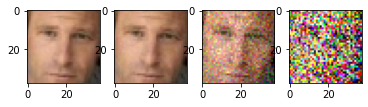

In [23]:
plt.subplot(1,4,1)
plt.imshow(X[0].transpose([1,2,0]))
plt.subplot(1,4,2)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]), sigma=0.01).data.numpy()[0].transpose([1,2,0]).clip(0, 1))
plt.subplot(1,4,3)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]), sigma=0.1).data.numpy()[0].transpose([1,2,0]).clip(0, 1))
plt.subplot(1,4,4)
plt.imshow(apply_gaussian_noise(torch.from_numpy(X[:1]), sigma=0.5).data.numpy()[0].transpose([1,2,0]).clip(0, 1))

In [24]:
aenc = PCAAutoencoder()
train(aenc, X_train_tensor, X_test_tensor, 50, noise_function=apply_gaussian_noise)

370it [00:03, 93.39it/s]


1, Train loss: 0.10957170627386828, Test loss: 0.023734273779598723


370it [00:03, 94.67it/s]


2, Train loss: 0.024289224276118876, Test loss: 0.023109818684124768


370it [00:03, 95.71it/s]


3, Train loss: 0.02396853529242196, Test loss: 0.022932771373792


370it [00:03, 95.98it/s]


4, Train loss: 0.023697354769126586, Test loss: 0.022565711219646196


370it [00:04, 92.17it/s]


5, Train loss: 0.02333351106315732, Test loss: 0.02221554139145751


370it [00:03, 95.89it/s]


6, Train loss: 0.022665486565277178, Test loss: 0.0215389962504905


370it [00:03, 96.08it/s]


7, Train loss: 0.021449010605002043, Test loss: 0.020263231103982086


370it [00:03, 95.39it/s]


8, Train loss: 0.01973820861297525, Test loss: 0.018717811949317043


370it [00:03, 94.37it/s]


9, Train loss: 0.01817176533674305, Test loss: 0.016882077198283902


370it [00:03, 94.50it/s]


10, Train loss: 0.01673213486728102, Test loss: 0.01547412283324789


370it [00:03, 94.84it/s]


11, Train loss: 0.01529630769308931, Test loss: 0.013994748968028317


370it [00:03, 93.88it/s]


12, Train loss: 0.013968602755709667, Test loss: 0.013342244653856966


370it [00:03, 95.13it/s]


13, Train loss: 0.012746526758139292, Test loss: 0.012097539105771568


370it [00:03, 94.76it/s]


14, Train loss: 0.011651259590702769, Test loss: 0.011168594371976525


370it [00:03, 96.90it/s]


15, Train loss: 0.010703133796593116, Test loss: 0.009879248233568647


370it [00:03, 96.22it/s]


16, Train loss: 0.00999258404690224, Test loss: 0.009719293095734959


370it [00:03, 96.82it/s]


17, Train loss: 0.009254047793125395, Test loss: 0.009292642309744595


370it [00:03, 96.63it/s]


18, Train loss: 0.008736417006971413, Test loss: 0.008359196003876536


370it [00:03, 96.48it/s]


19, Train loss: 0.008256929595832178, Test loss: 0.009704123498516258


370it [00:03, 93.37it/s]


20, Train loss: 0.007981032918412645, Test loss: 0.007579955111374071


370it [00:03, 95.59it/s]


21, Train loss: 0.007708600020832251, Test loss: 0.0075320984839064645


370it [00:03, 95.77it/s]


22, Train loss: 0.007486551368288044, Test loss: 0.0073191138730540365


370it [00:03, 96.36it/s]


23, Train loss: 0.007247189523614351, Test loss: 0.007316951695744198


370it [00:03, 96.72it/s]


24, Train loss: 0.007075536010761155, Test loss: 0.00691718131710022


370it [00:03, 95.16it/s]


25, Train loss: 0.006870325131056242, Test loss: 0.006655312954387376


370it [00:03, 95.74it/s]


26, Train loss: 0.006748538937069423, Test loss: 0.007499495797392381


370it [00:03, 96.36it/s]


27, Train loss: 0.006653155732580135, Test loss: 0.006821554669345765


370it [00:03, 93.97it/s]


28, Train loss: 0.006536894526988226, Test loss: 0.006481634507746127


370it [00:03, 95.29it/s]


29, Train loss: 0.006453890033155391, Test loss: 0.006226542425190773


370it [00:03, 96.12it/s]


30, Train loss: 0.00637575692054274, Test loss: 0.006404370489298277


370it [00:03, 95.98it/s]


31, Train loss: 0.006330789899150335, Test loss: 0.006575660043710281


370it [00:03, 96.97it/s]


32, Train loss: 0.006273886255542314, Test loss: 0.006270632650295869


370it [00:03, 96.38it/s]


33, Train loss: 0.006215960131632779, Test loss: 0.0063006092326072195


370it [00:03, 96.53it/s]


34, Train loss: 0.006149881708546969, Test loss: 0.006047763027727858


370it [00:03, 95.23it/s]


35, Train loss: 0.006086511364198578, Test loss: 0.006213973749315789


370it [00:03, 96.33it/s]


36, Train loss: 0.006096070486552618, Test loss: 0.00596238217956299


370it [00:03, 96.68it/s]


37, Train loss: 0.006017571054058124, Test loss: 0.006201046279607582


370it [00:03, 95.85it/s]


38, Train loss: 0.006009288352463871, Test loss: 0.005851251497990124


370it [00:03, 95.76it/s]


39, Train loss: 0.005970776739779681, Test loss: 0.006185236928007147


370it [00:03, 93.33it/s]


40, Train loss: 0.005971389349744069, Test loss: 0.005927226478931418


370it [00:03, 95.98it/s]


41, Train loss: 0.005944640038152406, Test loss: 0.005894395938771273


370it [00:03, 96.25it/s]


42, Train loss: 0.005936385264766799, Test loss: 0.006142492185206064


370it [00:03, 95.25it/s]


43, Train loss: 0.005918234063652957, Test loss: 0.005857819218231154


370it [00:03, 95.91it/s]


44, Train loss: 0.005928413024614462, Test loss: 0.005854436033645219


370it [00:03, 95.79it/s]


45, Train loss: 0.005926172730606841, Test loss: 0.005881037931892058


370it [00:03, 94.79it/s]


46, Train loss: 0.00586658617597591, Test loss: 0.005853807057248851


370it [00:03, 95.70it/s]


47, Train loss: 0.005884667684728655, Test loss: 0.0058232352108607225


370it [00:03, 95.62it/s]


48, Train loss: 0.005882604670522856, Test loss: 0.0058625859274545455


370it [00:04, 81.59it/s]


49, Train loss: 0.005875410880137995, Test loss: 0.005820011717610594


370it [00:04, 87.15it/s]


50, Train loss: 0.0058731816459999895, Test loss: 0.0057100180093808085


__Note:__ if it hasn't yet converged, increase the number of iterations.

__Bonus:__ replace gaussian noise with masking random rectangles on image.

Final MSE: 0.005830643679567491


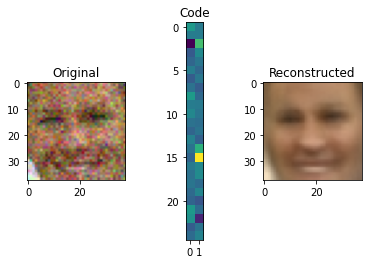

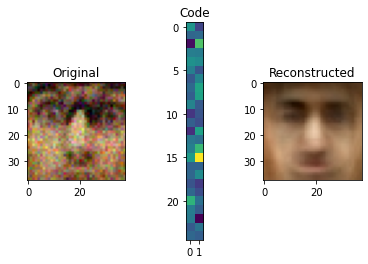

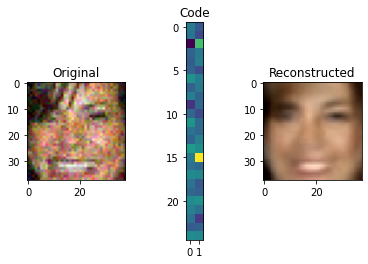

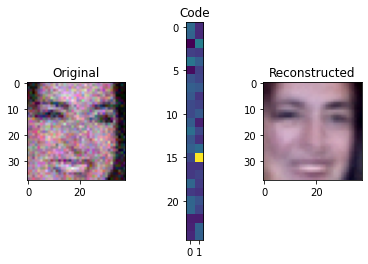

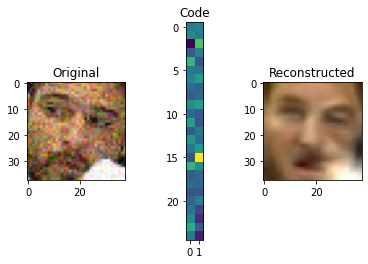

In [25]:
dataloader_test = DataLoader(X_test_tensor, batch_size=BATCH_SIZE, shuffle=True)
scores = []
for i, (batch) in enumerate(dataloader_test):
    batch_noised = apply_gaussian_noise(batch).to(device=device)
    scores.append(aenc.batch_loss(batch_noised, batch.cuda(device = device)).data.cpu().numpy())
    encoder_out = aenc.enc(batch_noised)
reconstruction_mse  = np.mean(scores)

print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = apply_gaussian_noise(X_test_tensor[i])
    visualize(img,aenc)

### Image retrieval with autoencoders

So we've just trained a network that converts image into itself imperfectly. This task is not that useful in and of itself, but it has a number of awesome side-effects. Let's see it in action.

First thing we can do is image retrieval aka image search. We we give it an image and find similar images in latent space. 

To speed up retrieval process, we shall use Locality-Sensitive Hashing on top of encoded vectors. We'll use scikit-learn's implementation for simplicity. In practical scenario, you may want to use [specialized libraries](https://erikbern.com/2015/07/04/benchmark-of-approximate-nearest-neighbor-libraries.html) for better performance and customization.

In [26]:
#encodes batch of images into a codes
codes = aenc.enc(X_train_tensor.to(device)).detach().cpu().numpy()

In [27]:
assert codes.shape[0] == X_train_tensor.shape[0]

In [32]:
from sklearn.neighbors import NearestNeighbors as NN
model_nb = NN(n_neighbors=50)
model_nb.fit(codes)

NearestNeighbors(n_neighbors=50)

In [33]:
images = torch.from_numpy(X_train).type(torch.DoubleTensor)

In [34]:
def get_similar(image, n_neighbors=5):
    assert len(image.shape) == 3, "image must be [batch, 3, height, width]"

    code = aenc.enc(image.cuda(device)).detach().cpu().numpy()
    
    (distances,),(idx,) = model_nb.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

In [35]:
def show_similar(image):
    distances, neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

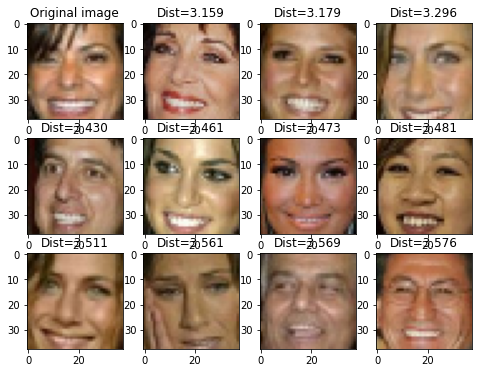

In [36]:
#smiles
show_similar(X_test_tensor[2])

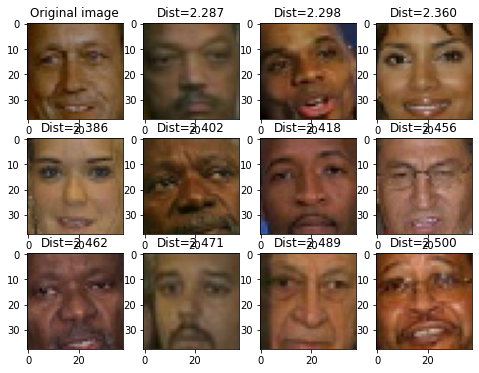

In [37]:
#ethnicity
show_similar(X_test_tensor[500])

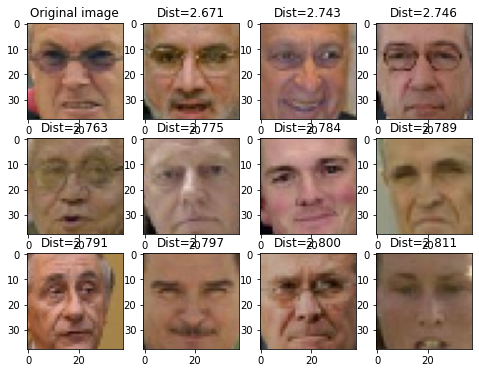

In [38]:
#glasses
show_similar(X_test_tensor[66])

## Bonus: cheap image morphing


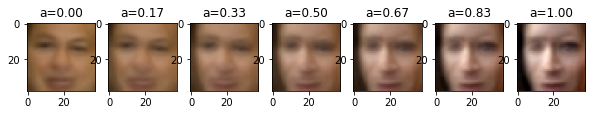

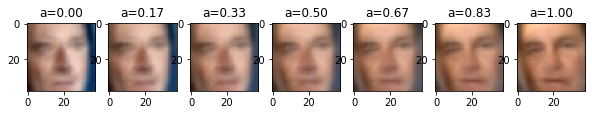

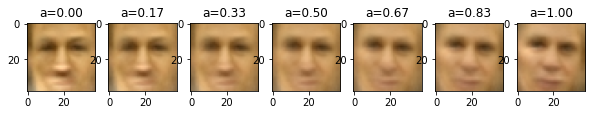

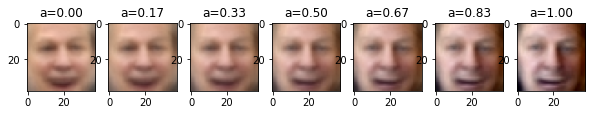

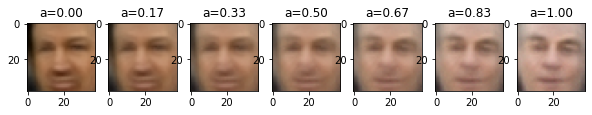

In [41]:
for _ in range(5):
    image1,image2 = X_test_tensor[np.random.randint(0,len(X_test),size=2)]

    image_pair = torch.cat((image1,image2), 0).cuda(device)
    # ^-- note: depending on your implementation, you may need to call torch.permute here
    
    code1, code2 = aenc.enc(image_pair)

    plt.figure(figsize=[10,4])
    for i,a in enumerate(np.linspace(0,1,num=7)):

        output_code = code1*(1-a) + code2*(a)
        output_image = aenc.dec(output_code[None])[0]
        plt.subplot(1,7,i+1)
        plt.imshow(output_image.cpu().detach().numpy().transpose([1,2,0]))
        plt.title("a=%.2f"%a)
        
    plt.show()

Of course there's a lot more you can do with autoencoders.
If you want to generate images from scratch, however, you're better off using generative adversarial networks.